In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def calculate_detected_intensities(df, threshold=0.8):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    Also add detectability column, where compounds with prediction value above threshold=0.8 are labelled as detected (1)
    '''

    df['detectability'] = df.pred_val >= threshold
    vals = df.spot_intensity_bgr_corrected * df.detectability
    df['effective_intensity'] = np.clip(vals, 0, None)
    return df

def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata

def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df

def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_data(data, adducts=None, neutral_losses=None):
    '''
    Apply adduct and neutral_loss filters
    '''
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    
    return data


def group_by_molecule_and_polarity(df):
    '''
    Aggregate intensity and detection values per metabolite and dataset
    '''
    
    data = df.pivot_table(index=['name_short', 'Matrix short', 'Polarity'],
                 values=['effective_intensity', 'detectability'],
                 aggfunc=
                        {'effective_intensity':'sum',
                        'detectability':'max'}).reset_index()
    return data

def summarise_per_class_and_polarity(df, class_col_name):
    
    data = df.pivot_table(index=['Polarity', 'Matrix short', class_col_name],
                      values=['effective_intensity', 'detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'effective_intensity':'mean',
                                'detectability':'sum'
                                }).reset_index()

    data['fraction_detected'] = data.detectability / data.class_size 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    
    data['log10_intensity'] = data.effective_intensity.apply(lambda x: np.log10(x+1))
    
    return data

def average_per_polarity(df, class_col_name):
    
    data = df.pivot_table(index=['Polarity', class_col_name],
                 values=['log10_intensity', 'fraction_detected'],
                 aggfunc=
                        {'log10_intensity':'mean',
                        'fraction_detected':'mean'}).reset_index()
    return data

def plot_revision_plot(data, cmap, class_col_name, intensity_col_name, title="", figsize=(12,4.5)):
    
    plt.figure(figsize=figsize)
    g = sns.scatterplot(data=data, 
                        x='Polarity', 
                        y=class_col_name, 
                        size="fraction_detected", 
                        sizes=(0, 400), #smallest and largest bubble size to use
                        size_norm=(0, 1), #fraction range
                        hue=intensity_col_name, 
                        hue_norm=(1, 5.5), #intensity range
                        palette=cmap,
                        linewidth = 0,
                        edgecolor='k',
                        legend='brief'
            )
    
    # Get the current x-tick labels
    xticks = g.get_xticks()
    yticks = g.get_yticks()

    # Add padding to the left by adjusting the limits
    padding = 0.5
    g.set(xlim = (-padding, len(xticks) - 1 + padding), 
           ylim=(-padding, len(yticks) - 1 + padding))
    
    sns.despine()

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=90)
    plt.tight_layout()

    return g

# size_norm and hue_norm make sure the same dot size and colour limits apply to all plots, 
# but it is not evident from the way legend is shown. If you want to double check, set legend='full' in plot function call

- Inputs

In [3]:
p_root_dir = Path.cwd().parents[1]
p_data = p_root_dir / "5_data"
p_out = p_root_dir / r"7_revisions/metaspace_revision"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / r"metadata/Datasets_14Jul2022.csv"

# Classification
p_chem_class = p_data / r"custom_classification/custom_classification_v2.csv"

- Merge relevant info into one dataframe

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                       'name_short', 
                                                       'adduct', 
                                                       'neutral_loss', 
                                                       'pred_val',
                                                       'spot_intensity_bgr_corrected']]
predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'EMBL']]

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Filter to keep only datasets chosen for plots about matrix comparison
df = df[df.EMBL]

# only consider data of detected ions
df = calculate_detected_intensities(df, threshold=0.8)
data = df[df.detectability]

In [5]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')

In [6]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

In [9]:
# Filter adducts and neutral losses
filtered_data = filter_data(data,
                            adducts=None,
                            neutral_losses=[''])

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule_and_polarity(filtered_data)

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class_and_polarity(mapped_data, class_col_name='main_coarse_class')

# Up to this point class data is just a combination of two class datas that were processed with polarity filter individually
# There is no need to zero-fill because each class in each polarity has a value

# Average individual data set results per polarity
plot_data = average_per_polarity(class_data, 'main_coarse_class')

# Set the order for axes
plot_data = plot_data.sort_values(by=['Polarity', 'main_coarse_class'], ascending=False)

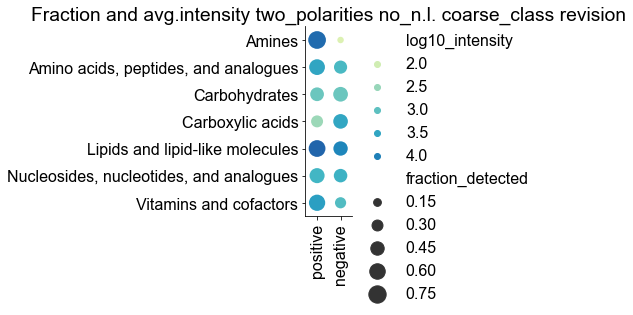

In [10]:
# Plot
p_out = p_root_dir / r"7_revisions/metaspace_revision"

title = f"Fraction and avg.intensity two_polarities no_n.l. coarse_class revision"
ax = plot_revision_plot(plot_data, 
                   cmap, 
                   class_col_name='main_coarse_class', 
                   intensity_col_name = 'log10_intensity',
                   title = title,
                   figsize=(7.8, 4.5))

plt.tight_layout()
ax.figure.savefig(p_out / f"{title}.png")
ax.figure.savefig(p_out / f"{title}.pdf", transparent=True)